In [22]:
import os
import time
import warnings
import pandas as pd
import numpy as np
from numpy import newaxis
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Convolution1D, MaxPooling1D, Flatten,  Embedding
from keras.layers import Conv1D, GlobalMaxPooling1D
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed, Bidirectional

In [2]:
master = pd.read_csv('master_timeseries.csv')

master=master.rename(columns={'Unnamed: 0':'Date'})

master=master.set_index('Date')

In [3]:
msft_df=pd.DataFrame(master['MSFT'])

In [12]:
dataset = msft_df.values

In [15]:
train = dataset[:int(0.8*(len(msft_df)))]
valid = dataset[int(0.8*(len(msft_df))):]

In [21]:
#converting dataset into x_train and y_train
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

In [46]:
#######

##### Method 1

In [29]:
# this method leaks. It uses valid information to predict forward. 

In [24]:
x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

In [25]:
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))

In [27]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))


In [28]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

Epoch 1/1
 - 211s - loss: 1.5793e-04


In [32]:
#predicting 246 values, using past 60 from the train data
inputs = msft_df[len(msft_df) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

In [33]:
X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

In [34]:
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [29]:
# Results

In [35]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

8.046828774894921

/Users/eharacz/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


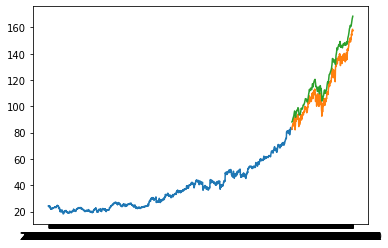

In [41]:
# plotting

train = msft_df[:2919] 
valid = msft_df[2919:]
valid['Predictions'] = closing_price
plt.plot(train['MSFT'])
plt.plot(valid[['MSFT','Predictions']])

#### Method 2

In [4]:
msft_df=msft_df.rename(columns={'MSFT':'Close'})

In [5]:
msft_df.head()

,Close
Date,
2010-01-04,24.294369
2010-01-05,24.302216
2010-01-06,24.153070
2010-01-07,23.901886
2010-01-08,24.066734


In [6]:
df=msft_df

In [7]:
def split_sequence(seq, n_steps_in, n_steps_out):
    """Splits the univariate time sequence"""
    X, y = [], []
    
    for i in range(len(seq)):
        end = i + n_steps_in
        out_end = end + n_steps_out
        
        if out_end > len(seq):
            break
        
        seq_x, seq_y = seq[i:end], seq[end:out_end]
        
        X.append(seq_x)
        y.append(seq_y)
    
    return np.array(X), np.array(y)

In [8]:
def visualize_training_results(results):
    """
    Plots the loss and accuracy for the training and testing data
    """
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(12,4))
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


In [9]:
# How many periods looking back to predict
n_per_in  = 730

# How many periods to predict
n_per_out = 365

# Features (in this case it's 1 because there is only one feature: price)
n_features = 1

# Splitting the data into appropriate sequences
X, y = split_sequence(list(df.Close), n_per_in, n_per_out)

# Reshaping the X variable from 2D to 3D
X = X.reshape((X.shape[0], X.shape[1], n_features))

In [26]:
model = Sequential()

# Activation
activ = "tanh" #relu

# Input layer
model.add(LSTM(50, activation=activ, return_sequences=True, input_shape=(n_per_in, n_features)))

# Hidden layers
model.add(Bidirectional(LSTM(50, activation=activ, return_sequences=True)))
model.add(Bidirectional(LSTM(50, activation=activ, return_sequences=True)))

#for _ in range(3):
   # model.add(LSTM(100, activation=activ, return_sequences=True))
    
# Final Hidden Layer
model.add(Bidirectional(LSTM(50, activation=activ)))
#model.add(LSTM(50, activation=activ))

# Output layer
model.add(Dense(n_per_out))

# Model summary
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_35 (LSTM)               (None, 730, 50)           10400     
_________________________________________________________________
bidirectional_4 (Bidirection (None, 730, 100)          40400     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 730, 100)          60400     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_5 (Dense)              (None, 365)               36865     
Total params: 208,465
Trainable params: 208,465
Non-trainable params: 0
_________________________________________________________________


In [27]:
# Compiling the data with specifications
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [28]:
res = model.fit(X, y, epochs=1, batch_size=122, validation_split=0.05) #batch size 

Train on 2427 samples, validate on 128 samples
Epoch 1/1
 122/2427 [>.............................] - ETA: 3:44 - loss: 3684.8284 - accuracy: 0.0000e+00

KeyboardInterrupt: 

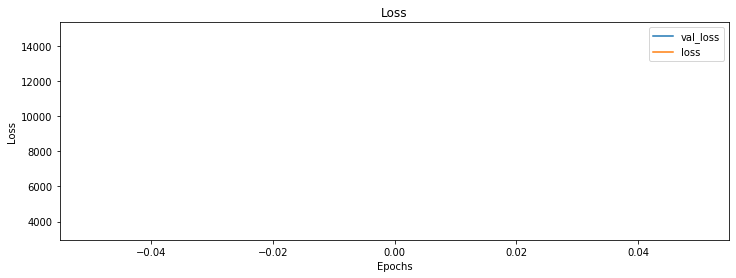

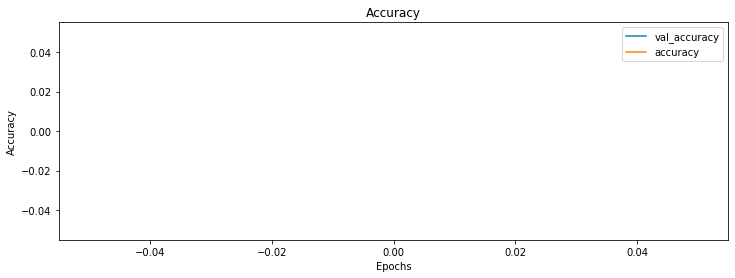

In [17]:
visualize_training_results(res)

Predicted:
 [0.8977571129798889, 1.0715868473052979, 1.069156527519226, 1.055222988128662, 0.6046233773231506, 0.1079062670469284, 1.0336774587631226, 0.952167272567749, 1.0955095291137695, 1.0978217124938965, 0.61993807554245, 1.3034846782684326, 0.1558552086353302, 0.5438706874847412, 0.7370861172676086, 0.48526278138160706, 0.6597996354103088, 1.0648984909057617, 1.0028400421142578, 0.26678401231765747, 1.0510797500610352, 1.2366926670074463, 1.6145414113998413, 0.978395402431488, -0.4100610017776489, 1.9383028745651245, -0.012877840548753738, 1.435418725013733, 0.839637041091919, 0.6746295094490051, 0.5991827845573425, 0.4444431960582733, 0.870362401008606, 0.4685077965259552, 1.554980754852295, 0.8362951874732971, 0.24157395958900452, 0.7548004388809204, 0.21330557763576508, 1.506437063217163, 1.7508139610290527, 1.5235494375228882, 0.018657518550753593, 0.6893991231918335, -0.5494939684867859, 1.202352523803711, 1.3049368858337402, 1.0832850933074951, 0.7973604202270508, 1.413894

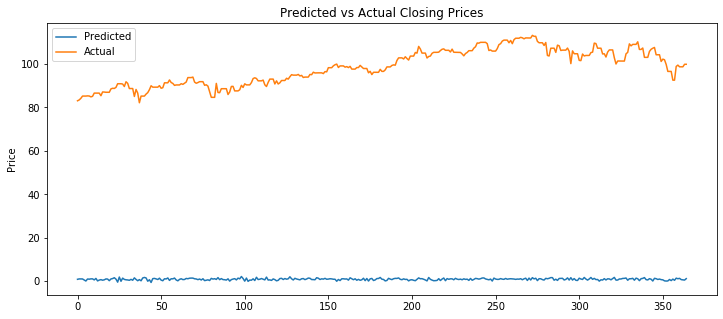

In [18]:
plt.figure(figsize=(12,5))
# Getting predictions
yhat = model.predict(X[-n_per_out].reshape(1, n_per_in, n_features)).tolist()[0]

# Printing and plotting those predictions
print("Predicted:\n", yhat)
plt.plot(yhat, label='Predicted')

# Printing and plotting the actual values
print("\nActual:\n", y[-n_per_out].tolist())
plt.plot(y[-n_per_out].tolist(), label='Actual')

plt.title(f"Predicted vs Actual Closing Prices")
plt.ylabel("Price")
plt.legend()
plt.show()

Predicted Prices:
 [0.8977301120758057, 1.0715526342391968, 1.0691293478012085, 1.055195927619934, 0.604619562625885, 0.10790793597698212, 1.0336401462554932, 0.9521418213844299, 1.0954865217208862, 1.097786545753479, 0.6199202537536621, 1.3034440279006958, 0.15585948526859283, 0.5438351631164551, 0.7370471954345703, 0.48524829745292664, 0.65977942943573, 1.0648808479309082, 1.002785325050354, 0.26677608489990234, 1.051042079925537, 1.236635446548462, 1.6144779920578003, 0.9783421754837036, -0.41005533933639526, 1.9382432699203491, -0.012869928032159805, 1.4353760480880737, 0.839609682559967, 0.6746358871459961, 0.599175751209259, 0.44441381096839905, 0.8703418970108032, 0.46850088238716125, 1.5549476146697998, 0.8362876176834106, 0.24155695736408234, 0.7547875046730042, 0.21329431235790253, 1.506395936012268, 1.7507516145706177, 1.523516058921814, 0.018653588369488716, 0.6893761157989502, -0.5494692921638489, 1.2023067474365234, 1.3048869371414185, 1.0832535028457642, 0.79733765125274

TypeError: Timestamp('2020-01-03 00:00:00', freq='W-FRI') is not a string

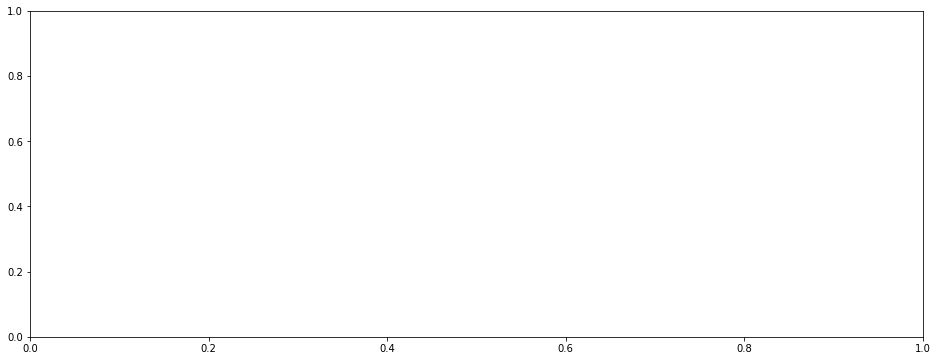

In [19]:
yhat = model.predict(np.array(df.tail(n_per_in)).reshape(1, n_per_in, n_features)).tolist()[0]
print("Predicted Prices:\n",yhat)

# Creating a DF of the predicted prices
preds = pd.DataFrame(yhat, index=pd.date_range(start=df.index[-1], periods=len(yhat), freq="1W-FRI"))

# Number of periods back to visualize the actual values
pers = 730

# Plotting
plt.figure(figsize=(16,6))
plt.plot(df.Close.tail(pers).append(preds.head(1)), label="Actual Prices")
plt.plot(preds, label="Predicted Prices")
plt.ylabel("Price")
plt.xlabel("Dates")
plt.title(f"Forecasting the next {len(yhat)} weeks")
plt.legend()
plt.show()